In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pydrake.all import (
    ModelVisualizer,
    StartMeshcat,
    Simulator,
    DiagramBuilder,
    ConstantValueSource,
    ConstantVectorSource,
    AbstractValue,
    RigidTransform,
    RotationMatrix,
)

from manipulation import running_as_notebook
from manipulation.station import MakeHardwareStation, load_scenario
import matplotlib.pyplot as plt
import numpy as np

import sponana.utils
from sponana.perception import (
    DummyBananaSpotter,
    add_camera_pose_extractor,
    add_body_pose_extractor,
)
BananaSpotter = DummyBananaSpotter
from sponana.controller import SpotController, solve_ik
from sponana.debug_logger import DebugLogger
from sponana.planner import Navigator
from sponana.grasping.grasp_system import Grasper

In [3]:
# Start the visualizer.
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7001


In [22]:
# BODY_NAME = "base_link_sugar"
# TARGET_OBJECT_PATH = "package://sponana/grasping/004_sugar_box.sdf"
# TARGET_OBJ_RPY_STR = "[0., 90., 0.]"

# # Switch to these to try with the banana (currently not quite working).
BODY_NAME = "banana"
TARGET_OBJECT_PATH = "package://sponana/banana/banana.sdf"
TARGET_OBJ_RPY_STR = "[0., 0., 0.]"

In [23]:
from pydrake.all import LeafSystem
class BitFlipSystem(LeafSystem):
    def __init__(self, flip_time):
        super().__init__()
        self._flip_time = flip_time

        self.DeclareVectorOutputPort("out", 1, self._set_output)
    
    def _set_output(self, context, output):
        if context.get_time() >= self._flip_time:
            output.SetFromVector([1])
        else:
            output.SetFromVector([0])

    #     self._out = self.DeclareDiscreteState(1)
    #     self.DeclareStateOutputPort("out", self._out)
    #     self.DeclareInitializationDiscreteUpdateEvent(self._init)
    #     self.DeclarePeriodicDiscreteUpdateEvent(offset_sec=0.0, periodic_sec=0.1, update=self._update)

    # def _init(self, context, state):
    #     state.set_value("out", [0])
        
    # def _update(self, context, state):
    #     if context.get_time() >= self._flip_time:
            # state.set_value("out", [1])

In [24]:
def create_scene(
    banana_pose, desired_base_position, scenario_data: str, debug: bool = True
):
    # Clean up the Meshcat instance.
    meshcat.Delete()
    meshcat.DeleteAddedControls()

    builder = DiagramBuilder()
    scenario = load_scenario(data=scenario_data)
    station = builder.AddSystem(
        sponana.utils.MakeSponanaHardwareStation(scenario, meshcat)
    )
    ts = station.GetSubsystemByName("plant").time_step()
    print(f"Time step: { ts } ")

    spot_plant = station.GetSubsystemByName(
        "spot.controller"
    ).get_multibody_plant_for_control()
    spot_controller = builder.AddSystem(
        SpotController(spot_plant, meshcat=meshcat, use_teleop=False)
    )
    builder.Connect(
        spot_controller.get_output_port(),
        station.GetInputPort("spot.desired_state"),
    )

    # Grasper
    grasper = builder.AddNamedSystem(
        "grasper",
        Grasper(
            target_obj_path=TARGET_OBJECT_PATH,
            target_obj_link=BODY_NAME,
            target_obj_rpy_str=TARGET_OBJ_RPY_STR,
            meshcat=meshcat,
            verbose=True,
        ),
    )
    builder.Connect(
        grasper.GetOutputPort("arm_position"),
        spot_controller.GetInputPort("desired_arm_position"),
    )
    builder.Connect(
        station.GetOutputPort("spot.state_estimated"),
        grasper.GetInputPort("spot_state"),
    )
    banana_pose_source = builder.AddNamedSystem(
        "banana_pose_source", ConstantValueSource(AbstractValue.Make(banana_pose))
    )
    builder.Connect(
        banana_pose_source.get_output_port(), grasper.GetInputPort("banana_pose")
    )
    do_grasp_source = builder.AddNamedSystem(
        "do_grasp_source", BitFlipSystem(1.0)
    )
    builder.Connect(
        do_grasp_source.GetOutputPort("out"),
        grasper.GetInputPort("do_grasp")
    )

    base_position_source = builder.AddNamedSystem(
        "base_position_source", ConstantVectorSource(desired_base_position)
    )
    builder.Connect(
        base_position_source.get_output_port(),
        spot_controller.GetInputPort("desired_base_position"),
    )

    # Get camera poses
    spot_camera_config = scenario.cameras["spot_camera"]
    camera_pose_extractor = add_camera_pose_extractor(
        spot_camera_config, station, builder
    )

    # Camera to Perception
    spot_camera = station.GetSubsystemByName("rgbd_sensor_spot_camera")
    banana_spotter = builder.AddSystem(BananaSpotter(spot_camera))
    banana_spotter.set_name("banana_spotter")
    builder.Connect(
        station.GetOutputPort("spot_camera.rgb_image"),
        banana_spotter.get_color_image_input_port(),
    )
    builder.Connect(
        station.GetOutputPort("spot_camera.depth_image"),
        banana_spotter.get_depth_image_input_port(),
    )

    # Banana pose (for debugging)
    banana_pose_extractor = add_body_pose_extractor(
        "banana", BODY_NAME, station, builder
    )
    # builder.Connect(
    #     banana_pose_extractor.get_output_port(),
    #     spot_controller.GetInputPort("desired_gripper_pose"),
    # )

    if debug:
        # Connect debugger
        debugger = builder.AddNamedSystem(
            "debug_logger", DebugLogger(spot_camera, meshcat)
        )
        builder.Connect(
            station.GetOutputPort("spot_camera.rgb_image"),
            debugger.get_color_image_input_port(),
        )
        builder.Connect(
            station.GetOutputPort("spot_camera.depth_image"),
            debugger.get_depth_image_input_port(),
        )
        builder.Connect(
            camera_pose_extractor.get_output_port(),
            debugger.get_camera_pose_input_port(),
        )
        builder.Connect(
            station.GetOutputPort("spot.state_estimated"),
            debugger.get_spot_state_input_port(),
        )
        builder.Connect(
            banana_pose_extractor.get_output_port(),
            debugger.get_banana_pose_input_port(),
        )

    diagram = builder.Build()
    diagram.set_name("everything")  # the outmost diagram
    return diagram

In [25]:
scenario_data = (
    """
cameras:
    spot_camera:
        name: spot_camera
        depth: True
        X_PB:
            translation: [0, 0.05, 0]
            base_frame: spot_camera::base
            rotation: !Rpy { deg: [-90, 0, 0] }

directives:
- add_model:
    name: spot
    file: package://sponana/spot.urdf
    default_joint_positions:
        # fold the arm
        arm_sh1: [-3.1]
        arm_el0: [3.1]
    
- add_model:
    name: banana
    file: """
    + TARGET_OBJECT_PATH
    + """
    default_free_body_pose:
        """
    + BODY_NAME
    + """:
            # move it in front of Spot 
            translation: [1.45, 0, 0.45]
            rotation: !Rpy { deg: """
    + TARGET_OBJ_RPY_STR
    + """ }

- add_model:
    name: floor
    file: package://sponana/platform.sdf

- add_weld:
    parent: world
    child: floor::platform_center

- add_model:
    name: spot_camera
    file: package://manipulation/camera_box.sdf

- add_weld:
    parent: spot::body
    child: spot_camera::base
    X_PC:
        translation: [0.4, 0, 0]
        rotation: !Rpy { deg: [-30, 0, -90] }

model_drivers:
    spot: !InverseDynamicsDriver {}
"""
)

In [26]:
from pydrake.all import RollPitchYaw

banana_pose = RigidTransform(
    R=RotationMatrix(
        [
            [0.9999107308839879, 0.009389862951888045, 0.009505826465590237],
            [-0.008962400073846544, 0.9989889507438625, -0.0440539632336637],
            [-0.009909876284064848, 0.04396483555549183, 0.9989839275917372],
        ]
    ),
    p=[1.4498836082822446, -0.0005091282959336326, 0.011183177445165213],
)  # @ RigidTransform(RollPitchYaw([0, 0, np.pi/2]).ToRotationMatrix())
desired_base_position = np.array([0.8, 1.01800645e-05, -1.21911880e-01])
diagram = create_scene(banana_pose, desired_base_position, scenario_data)
simulator = Simulator(diagram)
sponana.utils.run_simulation(simulator, meshcat, finish_time=10)

Time step: 0.001 
Press Space to log system info


==== LCM Warning ===
LCM detected that large packets are being received, but the kernel UDP
receive buffer is very small.  The possibility of dropping packets due to
insufficient buffer space is very high.

For more information, visit:
   http://lcm-proj.github.io/lcm/multicast_setup.html

==== LCM Warning ===
LCM detected that large packets are being received, but the kernel UDP
receive buffer is very small.  The possibility of dropping packets due to
insufficient buffer space is very high.

For more information, visit:
   http://lcm-proj.github.io/lcm/multicast_setup.html

==== LCM Warning ===
LCM detected that large packets are being received, but the kernel UDP
receive buffer is very small.  The possibility of dropping packets due to
insufficient buffer space is very high.

For more information, visit:
   http://lcm-proj.github.io/lcm/multicast_setup.html

==== LCM Warning ===
LCM detected that large packets are being received, but the kernel UDP
receive buffer is very small.  The 

BananaSpotter::Got images.
BananaSpotter::Displayed images.
BananaSpotter::set perception_completed to true
Beginning grasp sequence.
{'initial': RigidTransform(
  R=RotationMatrix([
    [0.000701432598147733, 0.9925565133758772, 0.12178290416734276],
    [-0.0008854659226537953, -0.12178226991257879, 0.9925564440801536],
    [0.9999993619710015, -0.0008040460569814143, 0.000793452914909297],
  ]),
  p=[1.234982211025779, -0.053219973497887006, 0.7970117783837577],
), 'post_init': RigidTransform(
  R=RotationMatrix([
    [0.000701432598147733, 0.9925565133758772, 0.12178290416734276],
    [-0.0008854659226537953, -0.12178226991257879, 0.9925564440801536],
    [0.9999993619710015, -0.0008040460569814143, 0.000793452914909297],
  ]),
  p=[1.3585944431968353, 0.13311308832688587, 0.7970900643610415],
), 'prepick': RigidTransform(
  R=RotationMatrix([
    [0.2181049377854877, -0.03418345583411819, 0.9753264722444612],
    [-0.8953482600038015, 0.3906322917702314, 0.2139109766573516],
    [

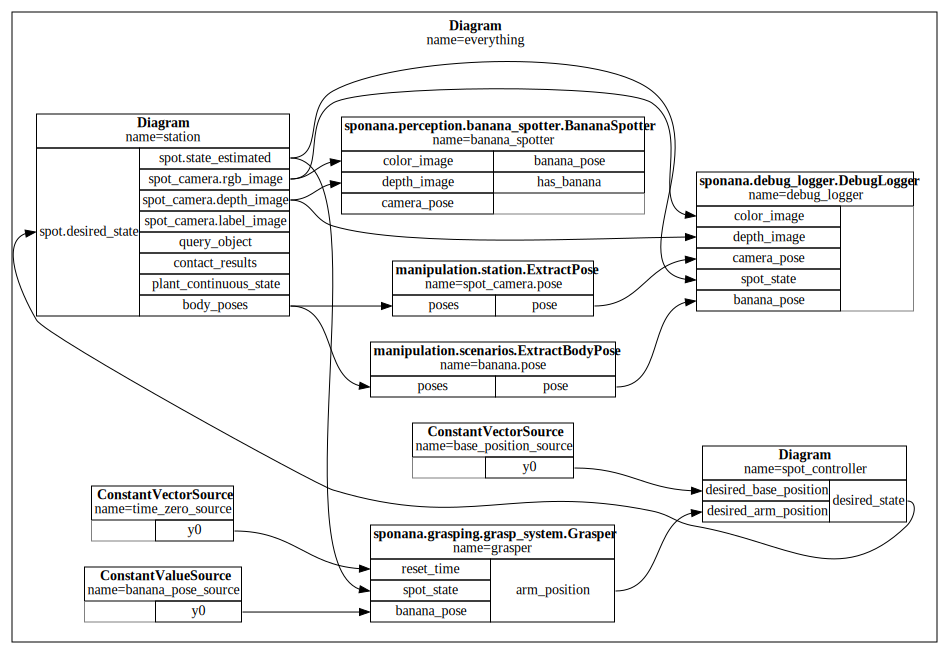

In [ ]:
sponana.utils.visualize_diagram(diagram, max_depth=1)